In [ ]:
import time
import numpy as np
from scipy import optimize
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy import log
from mpl_toolkits.mplot3d import Axes3D

# Pregunta 1

In [ ]:
x_prob = np.array([0.5,1.0,4.8,5.0])

y_prob = np.array([0,0,1,1])


In [ ]:

def neg_logverosimilitud(p,y,x):

  (a,b) = p
  suma, suma2 = 0, 0

  for i in range(len(y)):

      suma += y[i]*(a*x[i] + b) - y[i]*np.log(1+np.exp(a*x[i] + b))
      suma2 += (1-y[i])*np.log(1 + np.exp(a*x[i] + b));

  total = -(suma - suma2)


  return total

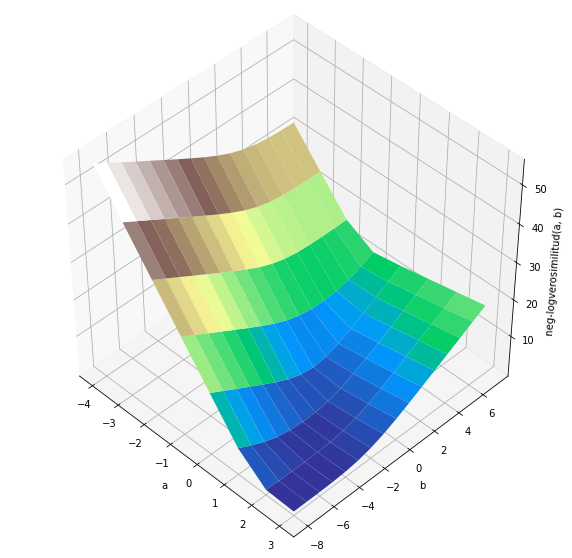

<Figure size 432x288 with 0 Axes>

In [ ]:
a = np.arange(-4, 4)
b = np.arange(-8, 8)
agrid, bgrid = np.meshgrid(a, b)
ab = np.stack([agrid, bgrid])



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(agrid, bgrid, neg_logverosimilitud(ab,y_prob,x_prob), cmap='terrain')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('neg-logverosimilitud(a, b)')
plt.show()

plt.savefig("plot_neg_log_verosimilitud.png")


# Pregunta 2

In [ ]:
x = np.array([0.5,1.0,1.5,2.2,2.5,3.0,3.1,4.0,4.5,4.5,4.8,5.0])
y = np.array([0,0,0,1,0,0,1,1,1,1,1,1])

## Newthon-Rapson

https://en.wikipedia.org/wiki/Newton%27s_method

In [ ]:
def gradiente_l(p,y,x):
  (a,b) = p
  m = len(y);
  dfa,dfb = 0, 0

  for i in range(m):
      dfa += -y[i]*x[i] + 1/(1+np.exp(a*x[i]+b))*np.exp(a*x[i]+b)*x[i]
      dfb += - y[i] +  1/(1+np.exp(a*x[i]+b))*np.exp(a*x[i]+b)
 
  return np.array([dfa,dfb])

In [ ]:
def hessiano_l(p,y,x):

    (a,b) = p
    m= len(y);
    a11 = 0;

  
    for i in range(m):
        a11 = a11 + np.exp(a*x[i]+b)/(1+np.exp(a*x[i]+b))*x[i]**2*(1-np.exp(a*x[i]+b)/(1+np.exp(a*x[i]+b)))

    a12 = 0;
    for i in range(m):
        a12 = a12 + np.exp(a*x[i]+b)/(1+np.exp(a*x[i]+b))*x[i]*(1-np.exp(a*x[i]+b)/(1+np.exp(a*x[i]+b)))

  
    a21 = a12;


    a22 = 0;
    for i in range(m):
        a22 = a22 + np.exp(a*x[i]+b)/(1+np.exp(a*x[i]+b))*(1-np.exp(a*x[i]+b)/(1+np.exp(a*x[i]+b)))

    return np.array([[a11,a12],[a21,a22]]);


In [ ]:
def newton_raphson(y, x, p_inicial, tol=1e-8, max_iter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"β":<30}{"Error":<30}'
        print(header)
        print("-" * len(header))

    β_old = p_inicial
    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached

    while np.any(error > tol) and i < max_iter:
        H, G = hessiano_l(β_old,y,x), gradiente_l(β_old,y,x)
        β_new = β_old - (np.linalg.inv(H) @ G)
        error = β_new - β_old
        β_old = β_new

        # Print iterations

        if display:
            β_list = [f'{t:.3}' for t in list(β_old.flatten())]
            error_list = [f'{t:.6}' for t in list([error[0],error[1]])]
            update = f'{i:<13}{neg_logverosimilitud(β_old,y,x):<16.8}{β_list}{error_list}'
            print(update)
        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {β_old.flatten()}')

    # Return a flat array for β (instead of a k_by_1 column vector)
    return β_old.flatten()

In [ ]:
import time
initial_time = time.time()
β_hat = newton_raphson(y, x, (1,-1))
print('Newton time: %f s'%(time.time() - initial_time))

Iteration_k  Log-likelihood  β                             Error                         
-----------------------------------------------------------------------------------------
0            3.8838254       ['1.26', '-3.46']['0.258776', '-2.45825']
1            3.5643119       ['1.74', '-4.72']['0.482594', '-1.26592']
2            3.5161778       ['2.02', '-5.44']['0.275079', '-0.718773']
3            3.5141869       ['2.09', '-5.63']['0.0710561', '-0.186308']
4            3.5141821       ['2.09', '-5.64']['0.00373978', '-0.00985075']
5            3.5141821       ['2.09', '-5.64']['9.60451e-06', '-2.53769e-05']
6            3.5141821       ['2.09', '-5.64']['6.29745e-11', '-1.66679e-10']
Number of iterations: 7
β_hat = [ 2.09125417 -5.63913179]
Newton time: 0.025604 s


## BGFS

https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm

In [ ]:

def logverosimilitud2(p):

  (a,b) = p
  x = np.array([0.5,1.0,1.5,2.2,2.5,3.0,3.1,4.0,4.5,4.5,4.8,5.0])
  y = np.array([0,0,0,1,0,0,1,1,1,1,1,1])


  suma, suma2 = 0, 0

  for i in range(len(y)):
      suma += y[i]*(a*x[i] + b) - y[i]*np.log(1+np.exp(a*x[i] + b))
      suma2 += (1-y[i])*np.log(1 + np.exp(a*x[i] + b));
  total = -(suma - suma2)

  

  return total

In [ ]:
def gradiente_l2(p):

    (a,b) = p
    x = np.array([0.5,1.0,1.5,2.2,2.5,3.0,3.1,4.0,4.5,4.5,4.8,5.0])
    y = np.array([0,0,0,1,0,0,1,1,1,1,1,1])
    m = len(y);
    dfa,dfb = 0, 0

    for i in range(m):
        dfa += -y[i]*x[i] + 1/(1+np.exp(a*x[i]+b))*np.exp(a*x[i]+b)*x[i]
        dfb += - y[i] +  1/(1+np.exp(a*x[i]+b))*np.exp(a*x[i]+b)

    return np.array([dfa,dfb])

Optimization terminated successfully.
         Current function value: 3.514182
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
       BFGS: time 0.01s, x error 0.00, f error 0.00
solucion con metodo: BFGS, (2.091254540710993,-5.639132499564706)
 


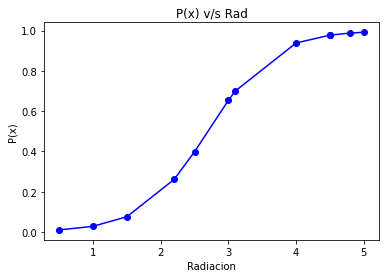

In [ ]:
# Compare different approaches

t0 = time.time()
x_bfgs = optimize.minimize(logverosimilitud2, (1,-1), jac=gradiente_l2, method="BFGS",options={'disp': True}).x
print('       BFGS: time %.2fs, x error %.2f, f error %.2f' % (time.time() - t0,
    np.sqrt(np.sum((x_bfgs - β_hat)**2)), logverosimilitud2(x_bfgs) - logverosimilitud2(β_hat)))
print("solucion con metodo: BFGS, ({},{})".format(x_bfgs[0],x_bfgs[1]))
print(" ")
p = []

x = np.sort(x)

for i in range(len(x)):
    p.append((np.exp(x_bfgs[1]+x_bfgs[0]*x[i])/(1+np.exp(x_bfgs[1]+x_bfgs[0]*x[i]))))



plt.plot(x,p,'-bo')   #### Deberia ser plt.plot(alphas,error)
plt.xlabel('Radiacion')
plt.ylabel('P(x)')
plt.title('P(x) v/s Rad')
plt.show()

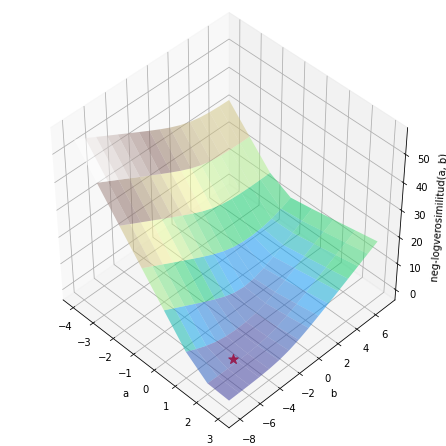

<Figure size 432x288 with 0 Axes>

In [ ]:
a = np.arange(-4, 4)
b = np.arange(-8, 8)
agrid, bgrid = np.meshgrid(a, b)
ab = np.stack([agrid, bgrid])



fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.view_init(45, -45)
ax.plot_surface(agrid, bgrid, neg_logverosimilitud(ab,y_prob,x_prob), cmap='terrain', alpha = 0.5)
ax.scatter(x_bfgs[0],x_bfgs[1],neg_logverosimilitud(x_bfgs,y,x), s= 100, c = 'red', marker = '*')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('neg-logverosimilitud(a, b)')
plt.show()

plt.savefig("plot_neg_log_verosimilitud.png")